# Определение стоимости автомобилей


## Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. Необходимо построить модель, которая умеет её определять.

**Признаки**

* `DateCrawled` — дата скачивания анкеты из базы

* `VehicleType` — тип автомобильного кузова

* `RegistrationYear` — год регистрации автомобиля

* `Gearbox` — тип коробки передач

* `Power` — мощность (л. с.)

* `Model` — модель автомобиля

* `Kilometer` — пробег (км)

* `RegistrationMonth` — месяц регистрации автомобиля

* `FuelType` — тип топлива

* `Brand` — марка автомобиля

* `Repaired` — была машина в ремонте или нет

* `DateCreated` — дата создания анкеты

* `NumberOfPictures` — количество фотографий автомобиля

* `PostalCode` — почтовый индекс владельца анкеты (пользователя)

* `LastSeen` — дата последней активности пользователя

**Целевой признак**

* `Price` — цена (евро)

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

C:\Users\gturk\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Изучение и предобработка данных

In [2]:
data = pd.read_csv('autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

После первичного анализа у меня возникли следующие мысли: во-первых, в данных есть неинформативные признаки (например, `PostalCode`, `LastSeen`, последний, на мой взгляд, неинформативен, так как совеременные системы позволяют настраивать, к примеру, оповещения на почту, если кто-то заинтересовался вашим товаром); во-вторых, некоторые признаки, возможно, стоит заменить, например, количество фотографий можно заменить на признак, показывающий наличие/отсутствие фотографий.

Изучим данные

### Изучение данных, удаление неинформативных признаков, обработка аномалий

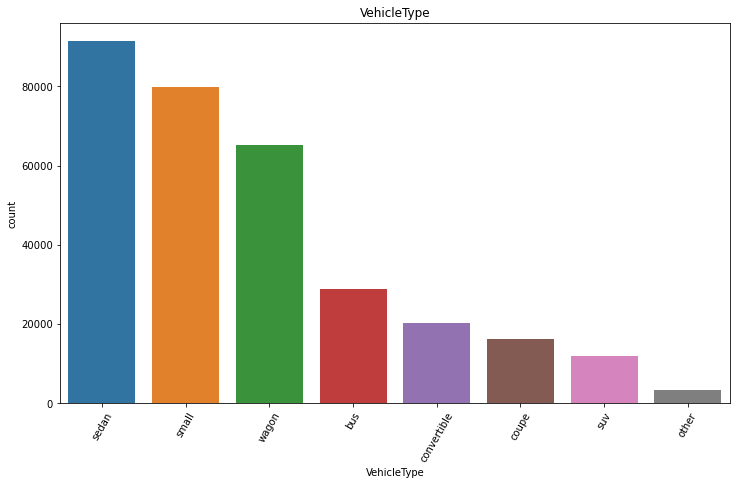

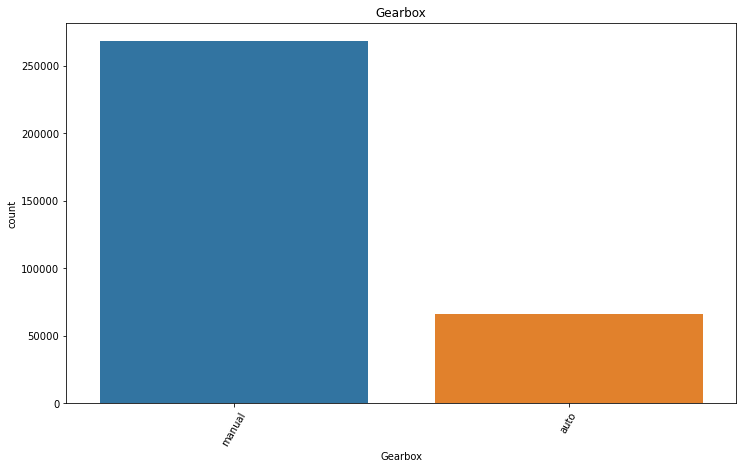

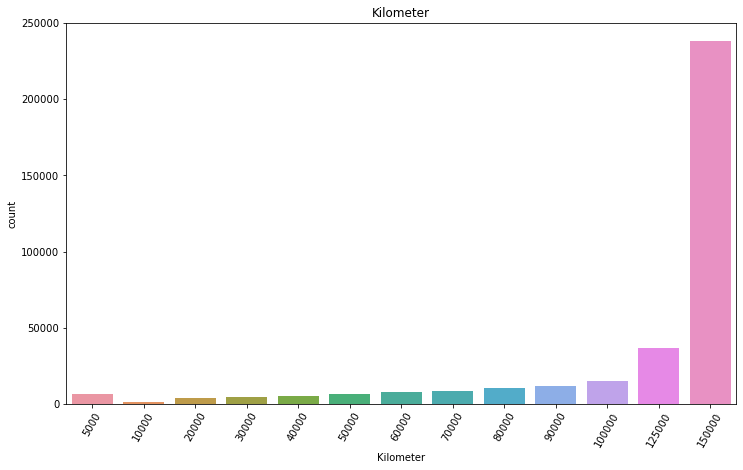

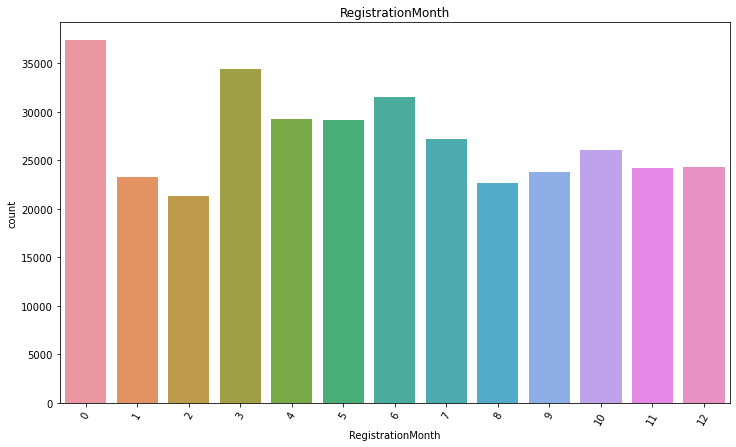

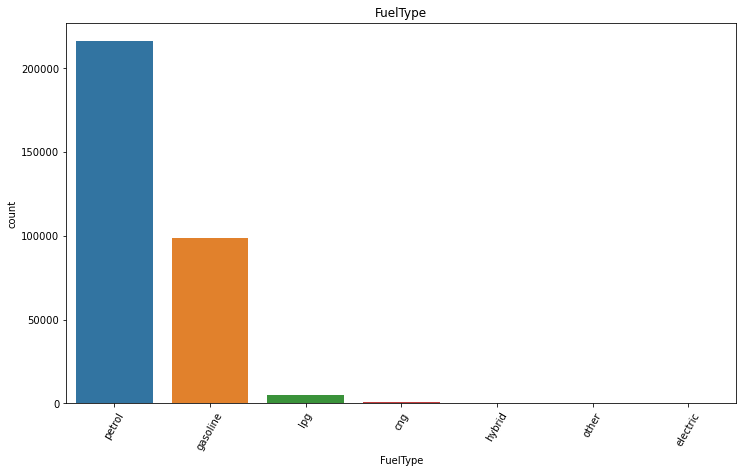

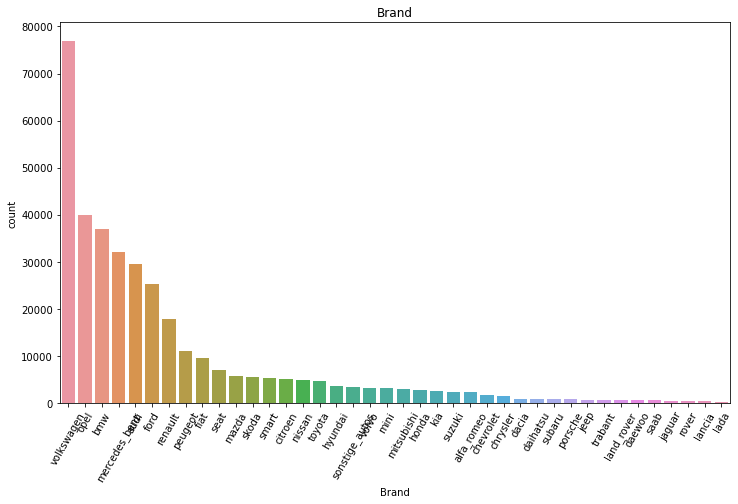

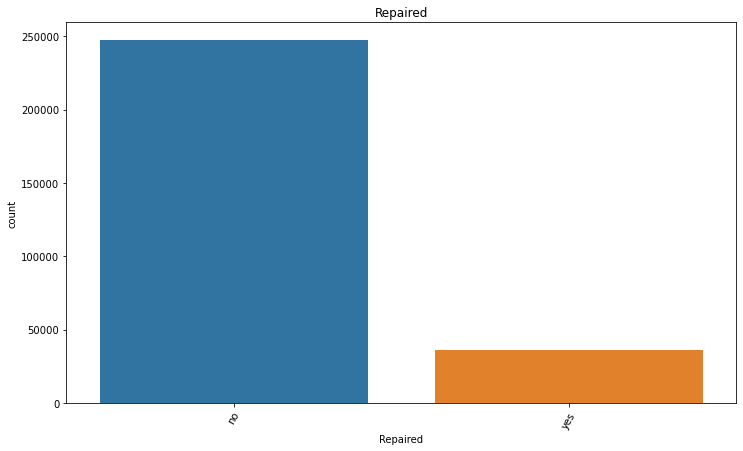

In [4]:
cols_to_plot = [
    'VehicleType',
    'Gearbox',
    'Kilometer',
    'RegistrationMonth',
    'FuelType',
    'Brand',
    'Repaired'
]

for col in cols_to_plot:
    pivot = data.pivot_table(index=col, values='Price', aggfunc='count').rename(columns={'Price':'count'})
    pivot = pivot.sort_values(by='count', ascending=False) #.reset_index()
    
    fig, ax = plt.subplots(figsize = (12, 7))
    graph = sns.barplot(x=pivot.index, y=pivot['count'], ax=ax)
    graph.set_xticklabels(graph.get_xticklabels(), rotation=60)
    graph.set_title(col)
    plt.show()

Из полученных графиков видно:

* Среди типов автомобильного кузова преобладают sedan, small и wagon

* Что касается, коробки - машин с ручной коробкой передач значительно больше, чем машин с автоматической

* Большинство автомобилей имеют пробег более 100 тыс км

* С месяцем регистрации произошло что-то странное: нумерация 0 - 12, то есть всего 13 месяцев, при этом больше всего автомобилей было зарегистрировано именно в месяц с номером 0

* Самый популярный тип топлива - бензин, следом за ним идет газ, правда, автомобилей на газовом топливе значительно меньше

* Лидирующий по количеству автомобилей бренд - volkswagen, последний - lada

* Также, согласно нашим данным, большинство автомобилей в ремонт не попадали

Теперь займемся поиском и обработкой пропусков

### Деление на выборки

In [5]:
features, target = data.drop('Price', axis=1), data['Price']

X_train, X_prom, y_train, y_prom = train_test_split(features, target, test_size=0.4, stratify=features['Brand'], 
                                                    random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_prom, y_prom, test_size=0.5, stratify=X_prom['Brand'], 
                                                random_state=42)

In [6]:
X_train.head()

,DateCrawled,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
107447,2016-03-29 20:55:55,sedan,1995,manual,75,golf,150000,5,petrol,volkswagen,no,2016-03-29 00:00:00,0,91174,2016-04-06 07:17:24
161380,2016-03-08 03:59:48,sedan,2006,auto,298,s_type,90000,3,petrol,jaguar,no,2016-03-08 00:00:00,0,77652,2016-03-25 08:47:13
210313,2016-03-26 13:47:37,NaN,2018,manual,75,NaN,150000,0,petrol,volkswagen,NaN,2016-03-26 00:00:00,0,45968,2016-04-06 01:46:38
194039,2016-03-14 16:44:28,sedan,2008,manual,143,a4,80000,11,gasoline,audi,NaN,2016-03-14 00:00:00,0,74226,2016-03-31 03:46:52
269188,2016-03-15 08:53:19,small,2012,manual,68,spark,60000,4,petrol,chevrolet,no,2016-03-15 00:00:00,0,63165,2016-04-05 18:15:25


In [7]:
X_val.head()

,DateCrawled,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
112005,2016-03-15 16:53:52,NaN,1995,NaN,0,NaN,150000,11,NaN,opel,NaN,2016-03-15 00:00:00,0,44623,2016-03-19 11:16:58
49235,2016-03-23 15:48:10,NaN,2016,manual,116,cooper,150000,11,petrol,mini,no,2016-03-23 00:00:00,0,89275,2016-04-03 18:17:40
74535,2016-04-04 21:51:41,wagon,2012,auto,122,passat,125000,5,petrol,volkswagen,no,2016-04-04 00:00:00,0,23738,2016-04-07 00:45:04
127976,2016-03-29 20:46:51,sedan,2008,auto,250,golf,150000,9,petrol,volkswagen,no,2016-03-29 00:00:00,0,89429,2016-04-06 06:46:58
262653,2016-04-03 14:53:23,wagon,2003,auto,0,a4,150000,4,petrol,audi,no,2016-04-03 00:00:00,0,92693,2016-04-05 14:15:29


In [8]:
X_test.head()

,DateCrawled,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
177202,2016-03-12 21:06:20,other,2008,manual,136,other,150000,0,gasoline,renault,NaN,2016-03-12 00:00:00,0,65205,2016-04-05 11:50:17
234024,2016-03-16 11:57:06,small,1998,manual,54,corsa,150000,9,petrol,opel,no,2016-03-16 00:00:00,0,58791,2016-03-17 10:15:29
75426,2016-03-10 13:48:15,sedan,2002,manual,116,147,150000,12,gasoline,alfa_romeo,no,2016-03-10 00:00:00,0,48531,2016-03-12 03:16:16
18850,2016-04-05 19:25:36,sedan,1998,manual,90,golf,150000,8,gasoline,volkswagen,yes,2016-04-05 00:00:00,0,65428,2016-04-05 19:25:36
170213,2016-03-11 11:50:51,sedan,2004,auto,205,e_klasse,150000,2,gasoline,mercedes_benz,NaN,2016-03-11 00:00:00,0,65428,2016-03-25 00:17:58


In [9]:
y_train.head(), y_val.head(), y_test.head()

(107447      799
 161380    10000
 210313     1250
 194039    15999
 269188     5000
 Name: Price, dtype: int64,
 112005      750
 49235      3500
 74535     16250
 127976    12567
 262653     4850
 Name: Price, dtype: int64,
 177202    6250
 234024     850
 75426     1100
 18850     1300
 170213    6900
 Name: Price, dtype: int64)

### Обработка пропусков

In [10]:
X_train.isna().sum()

DateCrawled              0
VehicleType          22413
RegistrationYear         0
Gearbox              11934
Power                    0
Model                11761
Kilometer                0
RegistrationMonth        0
FuelType             19694
Brand                    0
Repaired             42766
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [11]:
X_val.isna().sum()

DateCrawled              0
VehicleType           7630
RegistrationYear         0
Gearbox               3987
Power                    0
Model                 3948
Kilometer                0
RegistrationMonth        0
FuelType              6567
Brand                    0
Repaired             14226
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [12]:
X_test.isna().sum()

DateCrawled              0
VehicleType           7447
RegistrationYear         0
Gearbox               3912
Power                    0
Model                 3996
Kilometer                0
RegistrationMonth        0
FuelType              6634
Brand                    0
Repaired             14162
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Пропуски имеются в пяти колонках. Начнем с колонки `'Repaired'`, которая содержит информацию о том, была ли машина в ремонте. Большинство машин в ремонте не было, однако про часть машин (примерно 70 тыс строк - около 20% данных) мы не знаем ничего про ремонт. Мне кажется, уместно заполнить эти пропуски значением `'unknown'`

In [13]:
X_train['Repaired'] = X_train['Repaired'].fillna('unknown')
X_val['Repaired'] = X_val['Repaired'].fillna('unknown')
X_test['Repaired'] = X_test['Repaired'].fillna('unknown')

Теперь поработаем с пропусками в колонках `'VehicleType', 'Gearbox', 'FuelType'`, содержащих информацию о некоторых технических характеристиках автомобилей. Заполнять будем следующим образом: сгруппируем машины по маркам и моделям, в каждой группе найдем моду, используем ее для заполнения соответствующих пропусков

In [14]:
total_pivot = X_train.pivot_table(
    index=['Brand', 'Model'],
    values=['VehicleType', 'FuelType', 'Gearbox'],
    aggfunc=pd.Series.mode
)

total_pivot.head(15)

FuelType Gearbox  VehicleType
Brand      Model                                
alfa_romeo 145       petrol  manual        small
           147       petrol  manual        sedan
           156       petrol  manual        wagon
           159     gasoline  manual        wagon
           other     petrol  manual        sedan
           spider    petrol  manual  convertible
audi       100       petrol  manual        sedan
           200       petrol  manual        sedan
           80        petrol  manual        sedan
           90        petrol  manual        sedan
           a1        petrol  manual        small
           a2        petrol  manual        small
           a3        petrol  manual        sedan
           a4      gasoline  manual        wagon
           a5      gasoline  manual        coupe

In [15]:
for i in range(total_pivot.shape[0]):
    if isinstance(total_pivot['VehicleType'].iloc[i], np.ndarray):
        print(i, total_pivot['VehicleType'].iloc[i])

115 ['sedan' 'wagon']
132 []
217 ['convertible' 'suv']
220 ['small' 'suv']


In [16]:
total_pivot['VehicleType'].iloc[115] = 'sedan'
total_pivot['VehicleType'].iloc[217] = 'convertible'
total_pivot['VehicleType'].iloc[220] = 'small'

In [17]:
total_pivot.iloc[132]

FuelType       petrol
Gearbox            []
VehicleType        []
Name: (land_rover, serie_1), dtype: object

Заполним этот пропуск в сводной таблице модой по всей марке `'land_rover'`

In [18]:
X_train.loc[X_train['Brand'] == 'land_rover', 'VehicleType'].mode()

0    suv
Name: VehicleType, dtype: object

In [19]:
total_pivot['VehicleType'].iloc[132] = 'suv'

In [20]:
def find_value_in_pivot(row, col):
    try:
        return total_pivot.loc[row['Brand'], row['Model']][col]
    except:
        return 'unknown'

In [21]:
X_train.loc[~X_train['Model'].isna(), 'VehicleType'] = X_train.loc[~X_train['Model'].isna(), 'VehicleType'].fillna(
    X_train[~X_train['Model'].isna()].apply(
        lambda row: find_value_in_pivot(row, 'VehicleType'), axis=1
    )
)

In [22]:
X_val.loc[~X_val['Model'].isna(), 'VehicleType'] = X_val.loc[~X_val['Model'].isna(), 'VehicleType'].fillna(
    X_val[~X_val['Model'].isna()].apply(
        lambda row: find_value_in_pivot(row, 'VehicleType'), axis=1
    )
)

In [23]:
X_test.loc[~X_test['Model'].isna(), 'VehicleType'] = X_test.loc[~X_test['Model'].isna(), 'VehicleType'].fillna(
    X_test[~X_test['Model'].isna()].apply(
        lambda row: find_value_in_pivot(row, 'VehicleType'), axis=1
    )
)

In [24]:
print(X_train.loc[~X_train['Model'].isna(), 'VehicleType'].isna().sum())
print(X_val.loc[~X_val['Model'].isna(), 'VehicleType'].isna().sum())
print(X_test.loc[~X_test['Model'].isna(), 'VehicleType'].isna().sum())

0
0
0


In [25]:
for i in range(total_pivot.shape[0]):
    if isinstance(total_pivot['Gearbox'].iloc[i], np.ndarray):
        print(i, total_pivot['Gearbox'].iloc[i])

132 []


С этой ячейкой мы уже встречались. Марка - `'land_rover'`

In [26]:
X_train.loc[X_train['Brand'] == 'land_rover', 'Gearbox'].mode()

0    manual
Name: Gearbox, dtype: object

In [27]:
total_pivot['Gearbox'].iloc[132] = 'manual'

In [28]:
X_train.loc[~X_train['Model'].isna(), 'Gearbox'] = X_train.loc[~X_train['Model'].isna(), 'Gearbox'].fillna(
    X_train[~X_train['Model'].isna()].apply(
        lambda row: find_value_in_pivot(row, 'Gearbox'), axis=1
    )
)

In [29]:
X_val.loc[~X_val['Model'].isna(), 'Gearbox'] = X_val.loc[~X_val['Model'].isna(), 'Gearbox'].fillna(
    X_val[~X_val['Model'].isna()].apply(
        lambda row: find_value_in_pivot(row, 'Gearbox'), axis=1
    )
)

In [30]:
X_test.loc[~X_test['Model'].isna(), 'Gearbox'] = X_test.loc[~X_test['Model'].isna(), 'Gearbox'].fillna(
    X_test[~X_test['Model'].isna()].apply(
        lambda row: find_value_in_pivot(row, 'Gearbox'), axis=1
    )
)

In [31]:
print(X_train.loc[~X_train['Model'].isna(), 'Gearbox'].isna().sum())
print(X_val.loc[~X_val['Model'].isna(), 'Gearbox'].isna().sum())
print(X_test.loc[~X_test['Model'].isna(), 'Gearbox'].isna().sum())

0
0
0


In [32]:
for i in range(total_pivot.shape[0]):
    if isinstance(total_pivot['FuelType'].iloc[i], np.ndarray):
        print(i, total_pivot['FuelType'].iloc[i])

217 ['gasoline' 'petrol']
218 ['gasoline' 'petrol']
220 ['gasoline' 'petrol']
240 ['gasoline' 'petrol']


In [33]:
total_pivot['FuelType'].iloc[217] = 'gasoline'
total_pivot['FuelType'].iloc[218] = 'gasoline'
total_pivot['FuelType'].iloc[220] = 'gasoline'
total_pivot['FuelType'].iloc[240] = 'gasoline'

In [34]:
X_train.loc[~X_train['Model'].isna(), 'FuelType'] = X_train.loc[~X_train['Model'].isna(), 'FuelType'].fillna(
    X_train[~X_train['Model'].isna()].apply(
        lambda row: find_value_in_pivot(row, 'FuelType'), axis=1
    )
)

In [35]:
X_val.loc[~X_val['Model'].isna(), 'FuelType'] = X_val.loc[~X_val['Model'].isna(), 'FuelType'].fillna(
    X_val[~X_val['Model'].isna()].apply(
        lambda row: find_value_in_pivot(row, 'FuelType'), axis=1
    )
)

In [36]:
X_test.loc[~X_test['Model'].isna(), 'FuelType'] = X_test.loc[~X_test['Model'].isna(), 'FuelType'].fillna(
    X_test[~X_test['Model'].isna()].apply(
        lambda row: find_value_in_pivot(row, 'FuelType'), axis=1
    )
)

In [37]:
print(X_train.loc[~X_train['Model'].isna(), 'FuelType'].isna().sum())
print(X_val.loc[~X_val['Model'].isna(), 'FuelType'].isna().sum())
print(X_test.loc[~X_test['Model'].isna(), 'FuelType'].isna().sum())

0
0
0


Теперь заполним пропуски в колонке с моделью. Для этого сгруппируем по марке и для каждой марки найдем самую часто встречающуюся модель. После выполнения этой процедуры заполним те пропуски в колонках с типами топлива, кузова, коробки передач, которые не получилось заполнить при первом проходе

In [38]:
model_pivot = X_train.pivot_table(index='Brand', values='Model', aggfunc=pd.Series.mode)
model_pivot

,Model
Brand,
alfa_romeo,156
audi,a4
bmw,3er
chevrolet,other
chrysler,other
citroen,other
dacia,logan
daewoo,matiz
daihatsu,cuore


Во всех брендах значения вполне нормальные, только вот `sonstige_autos` подвел: самое частое значение - nan. Посмотрим, какие еще значения соответствуют этому бренду и в каком процентном соотношении

In [39]:
X_train.loc[X_train['Brand'] == 'sonstige_autos', 'Model'].unique()

array([nan], dtype=object)

Оказывается, nan - единственное значение... Возможно, все машины этой марки были одной модели. Заполним пропуски значением 'unknown'

In [40]:
X_train.loc[X_train['Brand'] == 'sonstige_autos', 'Model'] = 'unknown'

In [41]:
print(X_val.loc[X_val['Brand'] == 'sonstige_autos', 'Model'].unique())
print(X_test.loc[X_test['Brand'] == 'sonstige_autos', 'Model'].unique())

[nan]
[nan]


In [42]:
X_val.loc[X_val['Brand'] == 'sonstige_autos', 'Model'] = 'unknown'
X_test.loc[X_test['Brand'] == 'sonstige_autos', 'Model'] = 'unknown'

Приступим к заполнению основной массы пропусков

In [43]:
X_train['Model'] = X_train['Model'].fillna(
    X_train.apply(lambda row: model_pivot.loc[row['Brand'], 'Model'], axis=1)
)

X_val['Model'] = X_val['Model'].fillna(
    X_val.apply(lambda row: model_pivot.loc[row['Brand'], 'Model'], axis=1)
)

X_test['Model'] = X_test['Model'].fillna(
    X_test.apply(lambda row: model_pivot.loc[row['Brand'], 'Model'], axis=1)
)

In [44]:
X_train['Model'].isna().sum(), X_val['Model'].isna().sum(), X_test['Model'].isna().sum()

(0, 0, 0)

Теперь дозаполним пропуски в колонках `'FuelType', 'Gearbox', 'VehicleType'`. Сначала отдельно добавим марку `'sonstige_autos'`, потому что ее нет в общей сводной таблице, так как на момент формирования таблицы у всех машин этой марки в колонке `'Model'` стояли nan.

In [45]:
sonstige_autos_info = X_train.loc[X_train['Brand'] == 'sonstige_autos', ['FuelType', 'Gearbox', 'VehicleType']].mode()
sonstige_autos_info[['Brand', 'Model']] = ['sonstige_autos', 'unknown']
sonstige_autos_info = sonstige_autos_info.set_index(['Brand', 'Model'])
sonstige_autos_info

,,FuelType,Gearbox,VehicleType
Brand,Model,,,
sonstige_autos,unknown,petrol,manual,sedan


In [46]:
total_pivot = total_pivot.append(sonstige_autos_info)

C:\Users\gturk\AppData\Local\Temp\ipykernel_15996\2171991642.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_pivot = total_pivot.append(sonstige_autos_info)


In [47]:
X_train['VehicleType'] = X_train['VehicleType'].fillna(
    X_train.apply(lambda row: find_value_in_pivot(row, 'VehicleType'), axis=1)
)

In [48]:
X_train['Gearbox'] = X_train['Gearbox'].fillna(
    X_train.apply(lambda row: find_value_in_pivot(row, 'Gearbox'), axis=1)
)

In [49]:
X_train['FuelType'] = X_train['FuelType'].fillna(
    X_train.apply(lambda row: find_value_in_pivot(row, 'FuelType'), axis=1)
)

In [50]:
X_val['VehicleType'] = X_val['VehicleType'].fillna(
    X_val.apply(lambda row: find_value_in_pivot(row, 'VehicleType'), axis=1)
)

X_val['Gearbox'] = X_val['Gearbox'].fillna(
    X_val.apply(lambda row: find_value_in_pivot(row, 'Gearbox'), axis=1)
)

X_val['FuelType'] = X_val['FuelType'].fillna(
    X_val.apply(lambda row: find_value_in_pivot(row, 'FuelType'), axis=1)
)

In [51]:
X_test['VehicleType'] = X_test['VehicleType'].fillna(
    X_test.apply(lambda row: find_value_in_pivot(row, 'VehicleType'), axis=1)
)

X_test['Gearbox'] = X_test['Gearbox'].fillna(
    X_test.apply(lambda row: find_value_in_pivot(row, 'Gearbox'), axis=1)
)

X_test['FuelType'] = X_test['FuelType'].fillna(
    X_test.apply(lambda row: find_value_in_pivot(row, 'FuelType'), axis=1)
)

Проверим, остались ли пропуски в данных

In [52]:
X_train.isna().sum()

DateCrawled          0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

In [53]:
X_val.isna().sum()

DateCrawled          0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

In [54]:
X_test.isna().sum()

DateCrawled          0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

С пропусками разобрались. Переходим к следующему этапу - работе с дубликатами

### Работа с дубликатами

In [55]:
X_train.duplicated().sum()

1

In [56]:
X_train[X_train.duplicated()].index

Int64Index([231258], dtype='int64')

In [57]:
y_train = y_train.drop(index=231258)

In [58]:
X_train = X_train.drop_duplicates()

### Изучение аномалий и выбросов, удаление неинформативных столбцов

In [59]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212620 entries, 107447 to 66796
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        212620 non-null  object
 1   VehicleType        212620 non-null  object
 2   RegistrationYear   212620 non-null  int64 
 3   Gearbox            212620 non-null  object
 4   Power              212620 non-null  int64 
 5   Model              212620 non-null  object
 6   Kilometer          212620 non-null  int64 
 7   RegistrationMonth  212620 non-null  int64 
 8   FuelType           212620 non-null  object
 9   Brand              212620 non-null  object
 10  Repaired           212620 non-null  object
 11  DateCreated        212620 non-null  object
 12  NumberOfPictures   212620 non-null  int64 
 13  PostalCode         212620 non-null  int64 
 14  LastSeen           212620 non-null  object
dtypes: int64(6), object(9)
memory usage: 26.0+ MB


Избавимся от неинформативных столбцов. Подозрительными на неинформативность являются столбцы `'DateCreated', 'DateCrawled', 'NumberOfPictures', 'PostalCode', 'LastSeen'`. 

In [60]:
pd.to_datetime(X_train['DateCreated'], format='%Y-%m-%d %H:%M:%S').round('1d').describe(datetime_is_numeric=True)

count                           212620
mean     2016-03-20 19:03:41.397798656
min                2014-03-10 00:00:00
25%                2016-03-13 00:00:00
50%                2016-03-21 00:00:00
75%                2016-03-29 00:00:00
max                2016-04-07 00:00:00
Name: DateCreated, dtype: object

In [61]:
pd.to_datetime(X_train['DateCrawled'], format='%Y-%m-%d %H:%M:%S').round('1d').describe(datetime_is_numeric=True)

count                           212620
mean     2016-03-21 15:24:00.338632192
min                2016-03-06 00:00:00
25%                2016-03-14 00:00:00
50%                2016-03-22 00:00:00
75%                2016-03-30 00:00:00
max                2016-04-08 00:00:00
Name: DateCrawled, dtype: object

In [62]:
pd.to_datetime(X_train['LastSeen'], format='%Y-%m-%d %H:%M:%S').round('1d').describe(datetime_is_numeric=True)

count                           212620
mean     2016-03-30 00:06:14.256420096
min                2016-03-06 00:00:00
25%                2016-03-23 00:00:00
50%                2016-04-04 00:00:00
75%                2016-04-06 00:00:00
max                2016-04-08 00:00:00
Name: LastSeen, dtype: object

Все анкеты были созданы и скачаны примерно в одно время. Данные признаки не являются информативными. Также неинформативными признаками являются `'PostalCode', 'LastSeen'` (последний, на мой взгляд не является информативным хотя бы потому, что современные системы позволяют настраивать оповещения на почту или в соцсети, если товаром кто-то заинтересовался, кроме того, значения в этой колонке также не имеют большого разброса). Теперь изучим признак `'NumberOfPictures'`.

In [63]:
X_train['NumberOfPictures'].value_counts()

0    212620
Name: NumberOfPictures, dtype: int64

Видно, что он не несет в себе никакой информации. Также считаю необходимым удалить признак `'RegistrationMonth'`, так как с ним есть некоторая путаница, которая, очевидно, возникла из-за того, что в части данных нумерация месяца происходила от 0 до 11, а в другой части - от 1 до 12. Проверим отсутствие корреляции между этим и целевым признаками

In [64]:
y_train.corr(X_train['RegistrationMonth'])

0.10866786961241598

Корреляция отсутствует. График в начале исследования также подтверждает отсутствие серьезных взаимосвязей. Признак не является информативным.

Что касается года регистрации, то его нужно оставить, так как стоимость автомобиля напрямую зависит от его возраста: часто чем старше автомобиль, тем дешевле он стоит

In [65]:
cols_to_delete = ['NumberOfPictures', 'PostalCode', 'LastSeen', 'DateCreated', 'DateCrawled', 'RegistrationMonth']
X_train = X_train.drop(cols_to_delete, axis=1)
X_val = X_val.drop(cols_to_delete, axis=1)
X_test = X_test.drop(cols_to_delete, axis=1)

Теперь еще раз взглянем на данные и обработаем аномалии

In [66]:
X_train.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
107447,sedan,1995,manual,75,golf,150000,petrol,volkswagen,no
161380,sedan,2006,auto,298,s_type,90000,petrol,jaguar,no
210313,sedan,2018,manual,75,golf,150000,petrol,volkswagen,unknown
194039,sedan,2008,manual,143,a4,80000,gasoline,audi,unknown
269188,small,2012,manual,68,spark,60000,petrol,chevrolet,no


In [67]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212620 entries, 107447 to 66796
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       212620 non-null  object
 1   RegistrationYear  212620 non-null  int64 
 2   Gearbox           212620 non-null  object
 3   Power             212620 non-null  int64 
 4   Model             212620 non-null  object
 5   Kilometer         212620 non-null  int64 
 6   FuelType          212620 non-null  object
 7   Brand             212620 non-null  object
 8   Repaired          212620 non-null  object
dtypes: int64(3), object(6)
memory usage: 16.2+ MB


In [68]:
X_train.describe()

,RegistrationYear,Power,Kilometer
count,212620.000000,212620.000000,212620.000000
mean,2004.444121,109.949624,128156.711504
std,98.264778,183.262693,37933.179403
min,1000.000000,0.000000,5000.000000
25%,1999.000000,68.000000,125000.000000
50%,2003.000000,105.000000,150000.000000
75%,2008.000000,143.000000,150000.000000
max,9999.000000,19312.000000,150000.000000


Аномалии стоит искать только в числовых столбцах. Из вывода ячейки выше видно, что у нас слишком странные максимальное и минимальное значения года регистрации. Также есть автомобили с нереально маленькой и нереально большой мощностью двигателя. Про пробег ничего пока сказать нельзя. Построим графики

###### RegistrationYear

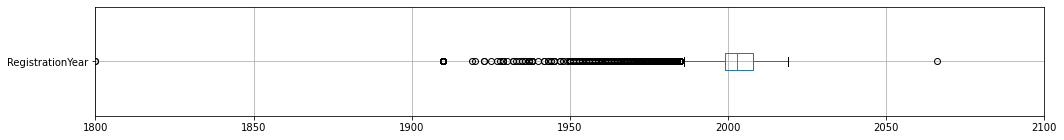

In [69]:
fig, ax = plt.subplots(figsize = (17,2))
ax = X_train[['RegistrationYear']].boxplot(vert=False, ax=ax)
ax.set_xlim(1800, 2100);

In [70]:
Q1 = X_train['RegistrationYear'].quantile(0.25)
Q3 = X_train['RegistrationYear'].quantile(0.75)
IQR = Q3 - Q1
upper = int(Q3 + 1.5 * IQR)
lower = int(Q1 - 1.5 * IQR)

In [71]:
lower, upper

(1985, 2021)

Однако в наших данных анкеты по всем машинам были выгружены в 2016 году. Поэтому этот год мы и возьмем в качестве верхней границы

In [72]:
upper = 2016

In [73]:
X_train.query("RegistrationYear > @upper or RegistrationYear < @lower")

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
210313,sedan,2018,manual,75,golf,150000,petrol,volkswagen,unknown
123158,coupe,2017,manual,180,tt,150000,petrol,audi,no
102740,sedan,2018,manual,139,golf,150000,petrol,volkswagen,no
32648,sedan,2017,manual,0,3er,150000,petrol,bmw,no
13087,sedan,2017,auto,0,a_klasse,5000,gasoline,mercedes_benz,unknown
...,...,...,...,...,...,...,...,...,...
321852,coupe,2018,auto,170,clk,150000,petrol,mercedes_benz,unknown
179530,small,2018,manual,71,twingo,20000,petrol,renault,no
36310,sedan,2018,manual,101,golf,150000,petrol,volkswagen,unknown
245126,wagon,2017,manual,101,a4,150000,gasoline,audi,no


In [74]:
X_train['RegistrationYear'] = X_train['RegistrationYear'].clip(lower=lower, upper=upper)
X_val['RegistrationYear'] = X_val['RegistrationYear'].clip(lower=lower, upper=upper)
X_test['RegistrationYear'] = X_test['RegistrationYear'].clip(lower=lower, upper=upper)

###### Kilometer

<AxesSubplot:>

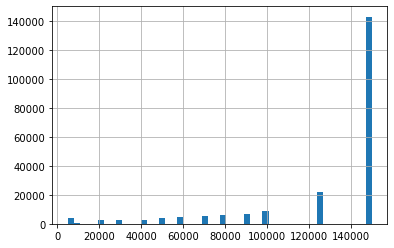

In [75]:
X_train['Kilometer'].hist(bins=50);

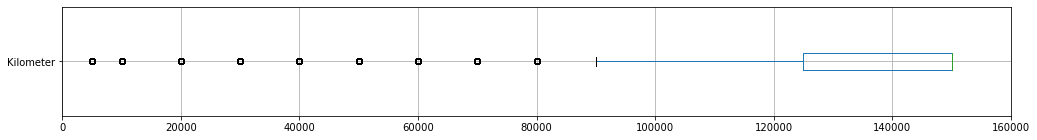

In [76]:
fig, ax = plt.subplots(figsize = (17,2))
ax = X_train[['Kilometer']].boxplot(vert=False, ax=ax)
ax.set_xlim(0, 160000);

Распределение явно скошено влево, поэтому определим только нижнюю границу для обработки аномалий

In [77]:
Q1 = X_train['Kilometer'].quantile(0.25)
Q3 = X_train['Kilometer'].quantile(0.75)
IQR = Q3 - Q1
lower = int(Q1 - 1.5 * IQR)
lower

87500

In [78]:
X_train[X_train['Kilometer'] < lower]

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
194039,sedan,2008,manual,143,a4,80000,gasoline,audi,unknown
269188,small,2012,manual,68,spark,60000,petrol,chevrolet,no
226245,bus,2005,manual,101,meriva,50000,petrol,opel,no
259085,small,2011,auto,61,fortwo,50000,petrol,smart,no
312721,small,2008,manual,58,twingo,50000,petrol,renault,no
...,...,...,...,...,...,...,...,...,...
263961,wagon,2000,auto,180,a6,5000,gasoline,audi,no
69884,sedan,2007,manual,109,ceed,70000,petrol,kia,no
333070,small,2002,manual,54,polo,70000,petrol,volkswagen,no
184079,small,1999,manual,54,corsa,30000,petrol,opel,no


In [79]:
X_train['Kilometer'] = X_train['Kilometer'].clip(lower=lower)
X_val['Kilometer'] = X_val['Kilometer'].clip(lower=lower)
X_test['Kilometer'] = X_test['Kilometer'].clip(lower=lower)

###### Power

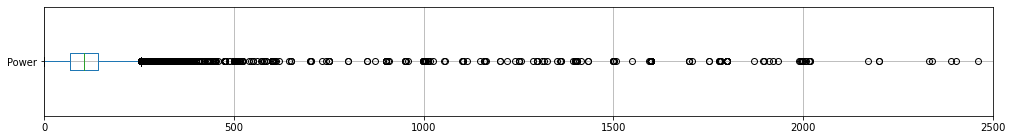

In [80]:
fig, ax = plt.subplots(figsize = (17,2))
ax = X_train[['Power']].boxplot(vert=False, ax=ax)
ax.set_xlim(0, 2500);

Первый в истории автомобиль был выпущен в 1885 году. Его мощность составляла 0.75 л.с. Примем это значение в качестве нижней границы, так как наше распределение скошено вправо, причем при расчете методом IQR значение нижней границы получается отрицательным...

In [81]:
Q1 = X_train['Power'].quantile(0.25)
Q3 = X_train['Power'].quantile(0.75)
IQR = Q3 - Q1
upper = Q3 + 1.5 * IQR
lower = 0.75
lower, upper

(0.75, 255.5)

Современные автомобили могут иметь уже гораздо большую мощность, чем та, которую мы получили в качестве верхней границы. Примем верхнюю границу равной 500 л.с. Все, что выше будем считать слишком мощными автомобилями

In [82]:
upper = 500

In [83]:
X_train.query("Power < @lower or Power > @upper")

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
94960,bus,2008,manual,0,other,100000,petrol,volkswagen,unknown
111991,small,1999,manual,0,corsa,150000,petrol,opel,no
198222,other,1999,auto,0,fortwo,150000,petrol,smart,yes
117617,wagon,1996,manual,0,unknown,150000,petrol,sonstige_autos,no
86704,wagon,2001,manual,0,v40,150000,petrol,volvo,unknown
...,...,...,...,...,...,...,...,...,...
40541,suv,2009,auto,0,cl,150000,petrol,mercedes_benz,yes
301641,wagon,2000,manual,0,4_reihe,150000,gasoline,peugeot,unknown
207794,sedan,2001,manual,0,3er,150000,petrol,bmw,no
344993,small,2002,manual,0,twingo,125000,petrol,renault,no


In [84]:
X_train['Power'] = X_train['Power'].clip(lower=lower, upper=upper)
X_val['Power'] = X_val['Power'].clip(lower=lower, upper=upper)
X_test['Power'] = X_test['Power'].clip(lower=lower, upper=upper)

###### Price

Посмотрим на распределение целевого признака

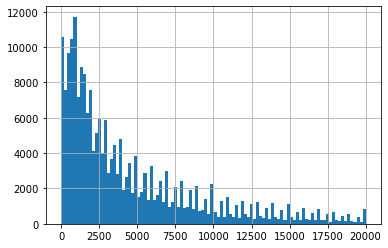

In [87]:
y_train.hist(bins=100);

Распределение явно скошено вправо. Причем имеются значительные пики около нуля. Посмотрим на описание этой колонки

In [88]:
y_train.describe()

count    212620.000000
mean       4425.403217
std        4525.404370
min           0.000000
25%        1050.000000
50%        2750.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

Стоимость большинства автомобилей лежит в пределах 6400 евро, однако есть автомобили, стоящие даже в три раза дороже... Также имеются автомобили, которые почему-то имеют нулевую стоимость...

In [89]:
y_train.value_counts()

0        6516
500      3412
1500     3261
1000     2842
1200     2702
         ... 
19495       1
834         1
3009        1
17255       1
1009        1
Name: Price, Length: 3058, dtype: int64

In [90]:
sorted(y_train.unique())[:150]

[0,
 1,
 2,
 3,
 4,
 5,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 25,
 26,
 27,
 30,
 33,
 35,
 38,
 39,
 40,
 45,
 49,
 50,
 55,
 59,
 60,
 65,
 69,
 70,
 75,
 77,
 79,
 80,
 85,
 88,
 89,
 90,
 95,
 98,
 99,
 100,
 105,
 110,
 111,
 112,
 115,
 117,
 119,
 120,
 121,
 122,
 123,
 125,
 126,
 128,
 129,
 130,
 132,
 133,
 135,
 140,
 142,
 145,
 149,
 150,
 155,
 156,
 157,
 158,
 159,
 160,
 165,
 166,
 169,
 170,
 173,
 175,
 177,
 179,
 180,
 181,
 185,
 188,
 189,
 190,
 193,
 195,
 198,
 199,
 200,
 202,
 205,
 209,
 210,
 215,
 217,
 219,
 220,
 222,
 224,
 225,
 229,
 230,
 235,
 240,
 243,
 245,
 248,
 249,
 250,
 251,
 252,
 253,
 255,
 259,
 260,
 261,
 263,
 265,
 266,
 269,
 270,
 272,
 273,
 274,
 275,
 277,
 278,
 279,
 280,
 281,
 285,
 289,
 290,
 293,
 295,
 298,
 299,
 300,
 301,
 309]

In [91]:
y_train[y_train > 12000].shape[0]

18384

Нулей довольно много - аж 6,5 тысяч. В процентном соотношении это около 3%. Также в данных автомобили стоимостью ниже 300 евро... Это крайне мало. Изменим нижнюю границу на 300 евро. Верхнюю границу трогать не будем по нескольким причинам: во-первых, стоимость автомобилей менялась со временем (у нас данные с 1985 по 2016 годы), во-вторых, всегда были какие-то автомобили, выделявшиеся среди других и, в-третьих, автомобилей стоимостью больше 12000 евро (это примерно 75-й квантиль плюс 1.5 IQR) около 10% от всех данных, а это значительная часть данных 

In [92]:
lower = 300
y_train = y_train.clip(lower=lower)

Итак, пропуски и аномалии обработаны, дубликаты и неинформативные признаки удалены. Проверим типы данных, при необходимости приведем их

In [93]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212620 entries, 107447 to 66796
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   VehicleType       212620 non-null  object 
 1   RegistrationYear  212620 non-null  int64  
 2   Gearbox           212620 non-null  object 
 3   Power             212620 non-null  float64
 4   Model             212620 non-null  object 
 5   Kilometer         212620 non-null  int64  
 6   FuelType          212620 non-null  object 
 7   Brand             212620 non-null  object 
 8   Repaired          212620 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 16.2+ MB


С типами все в порядке. Можно переходить к следующему этапу - к кодированию категориальных переменных и масштабированию количественных

### Кодирование категориальных и масштабирование количественных переменных

Если применять кодирование техникой one-hot encoding, то размерность датасета очень сильно возрастет. Поэтому применим ordinal encoding

In [94]:
var_categorical = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X_train_ordinal = pd.DataFrame(
    encoder.fit_transform(X_train[var_categorical]),
    columns=var_categorical
)

X_val_ordinal = pd.DataFrame(
    encoder.transform(X_val[var_categorical]),
    columns=var_categorical
)

X_test_ordinal = pd.DataFrame(
    encoder.transform(X_test[var_categorical]),
    columns=var_categorical
)

In [95]:
X_train_ordinal.head()

,VehicleType,Gearbox,Model,FuelType,Brand,Repaired
0,4.0,1.0,116.0,6.0,38.0,0.0
1,4.0,0.0,193.0,6.0,13.0,0.0
2,4.0,1.0,116.0,6.0,38.0,1.0
3,4.0,1.0,29.0,2.0,1.0,1.0
4,5.0,1.0,209.0,6.0,3.0,0.0


In [96]:
X_val_ordinal.head()

,VehicleType,Gearbox,Model,FuelType,Brand,Repaired
0,5.0,1.0,83.0,6.0,24.0,1.0
1,5.0,1.0,80.0,6.0,21.0,0.0
2,7.0,0.0,170.0,6.0,38.0,0.0
3,4.0,0.0,116.0,6.0,38.0,0.0
4,7.0,0.0,29.0,6.0,1.0,0.0


In [97]:
X_test_ordinal.head()

,VehicleType,Gearbox,Model,FuelType,Brand,Repaired
0,3.0,1.0,166.0,2.0,27.0,1.0
1,5.0,1.0,83.0,6.0,24.0,0.0
2,4.0,1.0,2.0,2.0,0.0,0.0
3,4.0,1.0,116.0,2.0,38.0,2.0
4,4.0,0.0,95.0,2.0,20.0,1.0


In [98]:
var_numeric = ['RegistrationYear', 'Power', 'Kilometer']

scaler = StandardScaler()

X_train_numeric = pd.DataFrame(
    scaler.fit_transform(X_train[var_numeric]),
    columns=var_numeric
)
X_val_numeric = pd.DataFrame(
    scaler.transform(X_val[var_numeric]),
    columns=var_numeric
)
X_test_numeric = pd.DataFrame(
    scaler.transform(X_test[var_numeric]),
    columns=var_numeric
)

In [99]:
X_train_enc = X_train_ordinal.join(X_train_numeric)
X_val_enc = X_val_ordinal.join(X_val_numeric)
X_test_enc = X_test_ordinal.join(X_test_numeric)

X_train_enc.shape, X_val_enc.shape, X_test_enc.shape

((212620, 9), (70874, 9), (70874, 9))

In [100]:
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

Некоторые модели, например, catboost и lightgbm позволяют напрямую работать с категориальными данными. Для них создадим еще один набор данных, в котором категориальные признаки останутся нетронутыми, а количественные будут отмасштабированы

In [101]:
X_train_scaled = X_train[var_categorical].reset_index(drop=True).join(X_train_numeric)
X_val_scaled = X_val[var_categorical].reset_index(drop=True).join(X_val_numeric)
X_test_scaled = X_test[var_categorical].reset_index(drop=True).join(X_test_numeric)

In [102]:
X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape

((212620, 9), (70874, 9), (70874, 9))

## Работа с моделями машинного обучения

In [103]:
def RMSE(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** 0.5

Для последующей проверки адекватности моделей обучим базовую модель - `DummyRegressor`

#### DummyRegressor

In [104]:
dummy = DummyRegressor()
%time dummy.fit(X_train_enc, y_train)
%time dummy_pred = dummy.predict(X_val_enc)
print(f'RMSE: {RMSE(y_val, dummy_pred) : .2f}')

CPU times: total: 0 ns
Wall time: 1 ms
CPU times: total: 0 ns
Wall time: 0 ns
RMSE:  4498.52


#### DecisionTreeRegressor

In [111]:
best_score = 99999999999999999
best_depth = 0
for depth in range(1, 7):
    tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    tree.fit(X_train_enc, y_train)
    rmse = RMSE(y_val, tree.predict(X_val_enc))
    if rmse < best_score:
        best_score = rmse
        best_depth = depth

print('Оптимальная глубина:', best_depth)
print(f'Метрика RMSE: {best_score : .2f}')

Оптимальная глубина: 6
Метрика RMSE:  2403.81


По итогам подбора параметров лучший результат показала модель с глубиной 6. Ее RMSE > 2500, то есть она не удовлетворяет требованиям заказчика. Посмотрим, сколько времени требуется ей, чтобы обучиться и выполнить предсказания

In [112]:
tree = DecisionTreeRegressor(max_depth=6, random_state=42)
%time tree.fit(X_train_enc, y_train)

CPU times: total: 172 ms
Wall time: 200 ms


DecisionTreeRegressor(max_depth=6, random_state=42)

In [113]:
%time tree_pred = tree.predict(X_val_enc)

CPU times: total: 0 ns
Wall time: 5 ms


In [114]:
print(f'RMSE: {RMSE(y_val, tree_pred) : .2f}')

RMSE:  2403.81


Безусловно, эта модель учится и предсказывает немного дольше, чем константная, но она сильно выигрывает в качестве. Однако это качество все еще не является приемлемым

#### RandomForestRegressor

In [115]:
numbers = list(range(10, 151, 10)) + [200]

best_score = 9999999999999999999999
best_number = 0
best_depth = 0
for number in numbers:
    for depth in range(1, 7):
        rf = RandomForestRegressor(n_estimators=number, max_depth=depth, random_state=42)
        rf.fit(X_train_enc, y_train)
        rmse = RMSE(y_val, rf.predict(X_val_enc))
        if rmse < best_score:
            best_score = rmse
            best_number = number
            best_depth = depth

print('Оптимальная глубина:', best_depth)
print('Оптимальное количество деревьев:', best_number)
print(f'Метрика RMSE: {best_score : .2f}')

Оптимальная глубина: 6
Оптимальное количество деревьев: 150
Метрика RMSE:  2345.54


По итогам подбора параметров лучший результат показала модель с глубиной 6 и количеством деревьев 150. RMSE < 2500

In [116]:
rf = RandomForestRegressor(max_depth=6, n_estimators=150, random_state=42)
%time rf.fit(X_train_enc, y_train)

CPU times: total: 15.7 s
Wall time: 18.3 s


RandomForestRegressor(max_depth=6, n_estimators=150, random_state=42)

In [117]:
%time rf_pred = rf.predict(X_val_enc)

CPU times: total: 328 ms
Wall time: 417 ms


In [118]:
print(f'RMSE: {RMSE(y_val, rf_pred) : .2f}')

RMSE:  2345.54


RMSE лучшей модели случайного леса меньше, чем RMSE одного дерева, однако время обучения и предсказания сильно выросло.

#### CatBoostRegressor на X_train_enc

In [119]:
numbers = list(range(10, 151, 10)) + [200]

best_score = 9999999999999999999999
best_number = 0
best_depth = 0
for number in numbers:
    for depth in range(1, 8):
        cb = CatBoostRegressor(n_estimators=number, depth=depth, random_seed=42, verbose=False)
        cb.fit(X_train_enc, y_train)
        rmse = RMSE(y_val, cb.predict(X_val_enc))
        if rmse < best_score:
            best_score = rmse
            best_number = number
            best_depth = depth

print('Оптимальная глубина:', best_depth)
print('Оптимальное количество деревьев:', best_number)
print(f'Метрика RMSE: {best_score : .2f}')

Оптимальная глубина: 7
Оптимальное количество деревьев: 200
Метрика RMSE:  1792.52


In [120]:
cb = CatBoostRegressor(n_estimators=200, depth=7, random_seed=42, verbose=False)
%time cb.fit(X_train_enc, y_train)

CPU times: total: 2.23 s
Wall time: 2.39 s


In [121]:
%time cb_pred = cb.predict(X_val_enc)

CPU times: total: 0 ns
Wall time: 10 ms


In [122]:
print(f'RMSE: {RMSE(y_val, cb_pred) : .2f}')

RMSE:  1792.52


Видно, что результаты, которые выдает catboost, гораздо лучше результатов всех предыдущих моделей: самое низкое значение RMSE, причем оно существенно ниже, чем у всех предыдущих моделей, время обучения в 6 раз ниже, чем у лучшей модели RandomForest, а время предсказания - аж в 40 раз!

#### CatBoostRegressor на X_train_scaled

In [123]:
numbers = list(range(10, 151, 10)) + [200]

best_score = 9999999999999999999999
best_number = 0
best_depth = 0
for number in numbers:
    for depth in range(1, 8):
        cb = CatBoostRegressor(
            n_estimators=number,
            depth=depth,
            cat_features=var_categorical,
            random_seed=42,
            verbose=False
        )
        cb.fit(X_train_scaled, y_train)
        rmse = RMSE(y_val, cb.predict(X_val_scaled))
        if rmse < best_score:
            best_score = rmse
            best_number = number
            best_depth = depth

print('Оптимальная глубина:', best_depth)
print('Оптимальное количество деревьев:', best_number)
print(f'Метрика RMSE: {best_score : .2f}')

Оптимальная глубина: 7
Оптимальное количество деревьев: 200
Метрика RMSE:  1787.30


In [124]:
cb = CatBoostRegressor(n_estimators=200, depth=7, cat_features=var_categorical, random_seed=42, verbose=False)
%time cb.fit(X_train_scaled, y_train)

CPU times: total: 14.2 s
Wall time: 18.9 s


In [125]:
%time cb_pred = cb.predict(X_val_scaled)

CPU times: total: 266 ms
Wall time: 160 ms


In [126]:
print(f'RMSE: {RMSE(y_val, cb_pred) : .2f}')

RMSE:  1787.30


RMSE этой модели практически не отличается от RMSE предыдущей. Однако время обучения значительно выше (примерно в 6 раз). Лучше обучать catboost на закодированных данных

#### LGBMRegressor на X_train_enc

In [127]:
numbers = list(range(10, 151, 10)) + [200]

best_score = 9999999999999999999999
best_number = 0
best_depth = 0
for number in numbers:
    for depth in range(1, 8):
        lgb = LGBMRegressor(metric='rmse', max_depth=depth, n_estimators=number, verbosity=-1, random_state=42)
        lgb.fit(X_train_enc, y_train)
        rmse = RMSE(y_val, lgb.predict(X_val_enc))
        if rmse < best_score:
            best_score = rmse
            best_number = number
            best_depth = depth

print('Оптимальная глубина:', best_depth)
print('Оптимальное количество деревьев:', best_number)
print(f'Метрика RMSE: {best_score : .2f}')

Оптимальная глубина: 7
Оптимальное количество деревьев: 200
Метрика RMSE:  1821.46


In [128]:
lgb = LGBMRegressor(metric='rmse', max_depth=7, n_estimators=200, verbosity=-1, random_state=42)
%time lgb.fit(X_train_enc, y_train)

CPU times: total: 6.06 s
Wall time: 563 ms


LGBMRegressor(max_depth=7, metric='rmse', n_estimators=200, random_state=42,
              verbosity=-1)

In [129]:
%time lgb_pred = lgb.predict(X_val_enc)

CPU times: total: 1.45 s
Wall time: 135 ms


In [130]:
print(f'RMSE: {RMSE(y_val, lgb_pred) : .2f}')

RMSE:  1821.46


Качество ниже, чем у catboost, обученного на `X_train_enc`, зато время обучения ниже

#### LGBMRegressor на X_train_cat

Чтобы передать в `LGBMRegressor()` незакодированные категориальные данные, их необходимо перевести в специальный тип: `'category'`.

In [131]:
X_train_cat = X_train_scaled.copy()
X_train_cat[var_categorical] = X_train_cat[var_categorical].astype("category")
X_train_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212620 entries, 0 to 212619
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   VehicleType       212620 non-null  category
 1   Gearbox           212620 non-null  category
 2   Model             212620 non-null  category
 3   FuelType          212620 non-null  category
 4   Brand             212620 non-null  category
 5   Repaired          212620 non-null  category
 6   RegistrationYear  212620 non-null  float64 
 7   Power             212620 non-null  float64 
 8   Kilometer         212620 non-null  float64 
dtypes: category(6), float64(3)
memory usage: 6.3 MB


In [132]:
X_val_cat = X_val_scaled.copy()
X_val_cat[var_categorical] = X_val_cat[var_categorical].astype("category")
X_val_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70874 entries, 0 to 70873
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   VehicleType       70874 non-null  category
 1   Gearbox           70874 non-null  category
 2   Model             70874 non-null  category
 3   FuelType          70874 non-null  category
 4   Brand             70874 non-null  category
 5   Repaired          70874 non-null  category
 6   RegistrationYear  70874 non-null  float64 
 7   Power             70874 non-null  float64 
 8   Kilometer         70874 non-null  float64 
dtypes: category(6), float64(3)
memory usage: 2.1 MB


In [133]:
X_test_cat = X_test_scaled.copy()
X_test_cat[var_categorical] = X_test_cat[var_categorical].astype("category")
X_test_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70874 entries, 0 to 70873
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   VehicleType       70874 non-null  category
 1   Gearbox           70874 non-null  category
 2   Model             70874 non-null  category
 3   FuelType          70874 non-null  category
 4   Brand             70874 non-null  category
 5   Repaired          70874 non-null  category
 6   RegistrationYear  70874 non-null  float64 
 7   Power             70874 non-null  float64 
 8   Kilometer         70874 non-null  float64 
dtypes: category(6), float64(3)
memory usage: 2.1 MB


In [134]:
numbers = list(range(10, 151, 10)) + [200]

best_score = 9999999999999999999999
best_number = 0
best_depth = 0
for number in numbers:
    for depth in range(1, 8):
        lgb = LGBMRegressor(metric='rmse', max_depth=depth, n_estimators=number, verbosity=-1, random_state=42)
        lgb.fit(X_train_cat, y_train)
        rmse = RMSE(y_val, lgb.predict(X_val_cat))
        if rmse < best_score:
            best_score = rmse
            best_number = number
            best_depth = depth

print('Оптимальная глубина:', best_depth)
print('Оптимальное количество деревьев:', best_number)
print(f'Метрика RMSE: {best_score : .2f}')

Оптимальная глубина: 7
Оптимальное количество деревьев: 200
Метрика RMSE:  1770.04


In [135]:
lgb = LGBMRegressor(metric='rmse', max_depth=7, n_estimators=200, verbosity=-1, random_state=42)
%time lgb.fit(X_train_cat, y_train)

CPU times: total: 7.19 s
Wall time: 660 ms


LGBMRegressor(max_depth=7, metric='rmse', n_estimators=200, random_state=42,
              verbosity=-1)

In [136]:
%time lgb_pred = lgb.predict(X_val_cat)

CPU times: total: 1.75 s
Wall time: 174 ms


In [137]:
print(f'RMSE: {RMSE(y_val, lgb_pred) : .2f}')

RMSE:  1770.04


Убедимся в отсутствии переобучения

In [138]:
%time lgb_pred = lgb.predict(X_train_cat)

CPU times: total: 4.75 s
Wall time: 424 ms


In [139]:
print(f'RMSE: {RMSE(y_train, lgb_pred) : .2f}')

RMSE:  1704.06


Данная модель `LGBMregressor` выигрывает у `CatBoostRegressor` по качеству и по времени обучения, но проигрывает по времени предсказания.

## Выбор лучшей модели и проведение итогового тестирования

Составим небольшую сводку по характеристикам моделей


| Модель                               | RMSE            | Время обучения     | Время предсказания |
:--------------------------------------|:---------------:|:------------------:|:------------------:|
| DecisionTreeRegressor                | 2749.26         | 191 ms             | 10.4 ms            |
| RandomForestRegressor                | 2697.92         | 8.49 s             | 190 ms             |
| CatBoostRegressor на X_train_enc     | 2012.15         | 2.68 s             | 10.4 ms            |
| CatBoostRegressor на X_train_scaled  | 2012.04         | 32.3 s             | 201 ms             |
| LGBMRegressor на X_train_enc         | 2053.22         | 707 ms             | 141 ms             |
| LGBMRegressor на X_train_cat         | 1966.37         | 675 ms             | 168 ms             |


Для финального тестирования выберем модель `LGBMRegressor` на X_train_cat. Во-первых, эта модель выдала лучшее значение RMSE. Во-вторых, она обучается значительно быстрее `CatBoostRegressor` - единственного класса моделей, составившего конкуренцию. При этом, несмотря на то, что время предсказания у `CatBoostRegressor` на порядок меньше, данная модель предсказывает достаточно быстро, чтобы ее можно было использовать даже в real-time-сервисах

Соединим тренировочную и валидационную выборки в одну и протестируем нашу модель

In [151]:
features_train = pd.concat([X_train_cat, X_val_cat]).reset_index(drop=True)
target_train = pd.concat([y_train, y_val]).reset_index(drop=True)

In [152]:
features_train.head()

,VehicleType,Gearbox,Model,FuelType,Brand,Repaired,RegistrationYear,Power,Kilometer
0,sedan,manual,golf,petrol,volkswagen,no,-1.232933,-0.018479,0.646188
1,sedan,auto,s_type,petrol,jaguar,no,0.417870,-0.018479,-1.767210
2,sedan,manual,golf,petrol,volkswagen,unknown,1.918601,-0.018479,0.646188
3,sedan,manual,a4,gasoline,audi,unknown,0.718016,-0.018479,-1.867769
4,small,manual,spark,petrol,chevrolet,no,1.318309,-0.018479,-1.867769


In [153]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283494 entries, 0 to 283493
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   VehicleType       283494 non-null  category
 1   Gearbox           283494 non-null  category
 2   Model             283494 non-null  object  
 3   FuelType          283494 non-null  category
 4   Brand             283494 non-null  category
 5   Repaired          283494 non-null  category
 6   RegistrationYear  283494 non-null  float64 
 7   Power             283494 non-null  float64 
 8   Kilometer         283494 non-null  float64 
dtypes: category(5), float64(3), object(1)
memory usage: 10.0+ MB


In [154]:
features_train['Model'] = features_train['Model'].astype('category')

In [155]:
features_train['Model'].dtype

CategoricalDtype(categories=['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
                  '2_reihe', '300c',
                  ...
                  'wrangler', 'x_reihe', 'x_trail', 'x_type', 'xc_reihe',
                  'yaris', 'yeti', 'ypsilon', 'z_reihe', 'zafira'],
, ordered=False)

In [156]:
target_train.head()

0      799
1    10000
2     1250
3    15999
4     5000
Name: Price, dtype: int64

In [157]:
target_train.info()

<class 'pandas.core.series.Series'>
RangeIndex: 283494 entries, 0 to 283493
Series name: Price
Non-Null Count   Dtype
--------------   -----
283494 non-null  int64
dtypes: int64(1)
memory usage: 2.2 MB


In [158]:
model = LGBMRegressor(metric='rmse', max_depth=7, n_estimators=200, verbosity=-1, random_state=42)
%time model.fit(features_train, target_train)

CPU times: total: 10.4 s
Wall time: 975 ms


LGBMRegressor(max_depth=7, metric='rmse', n_estimators=200, random_state=42,
              verbosity=-1)

In [159]:
%time model_pred = model.predict(X_test_cat)

CPU times: total: 1.8 s
Wall time: 188 ms


In [160]:
print(f'RMSE: {RMSE(y_test, model_pred) : .2f}')

RMSE:  1968.18


Убедимся в отсутствии переобучения

In [161]:
%time model_pred = model.predict(features_train)

CPU times: total: 6.36 s
Wall time: 591 ms


In [162]:
print(f'RMSE: {RMSE(target_train, model_pred) : .2f}')

RMSE:  1918.05


Модель показала практически тот же результат, что и на валидационной выборке.

Посмотрим, какие признаки оказались важны в итоге

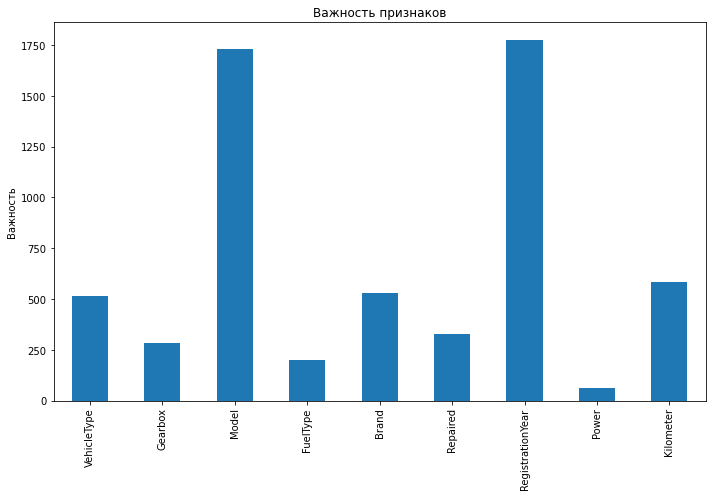

In [166]:
feat_imp = pd.Series(model.feature_importances_, features_train.columns)

fig, ax = plt.subplots(figsize=(10,7))
feat_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

Видим, что наиболее значимыми оказались `'Model'` и `'RegistrationYear'`, далее идут `'Vehicletype', 'Brand', 'Kilometer'`. Остальные признаки менее значимы.

## Вывод


* В ходе исследования были изучены разные модели машинного обучения, начиная от простейших - `DecisionTree` и кончая различными реализациями градиентного бустинга

* Основными конкурентами на протяжении всего исследования являлись `CatBoostRegressor` и `LGBMRegressor`. В конечном итоге предпочтение было отдано модели `LGBMRegressor`, обученной на незакодированных данных, так как ее метрика RMSE оказалась самой маленькой, а время обучения было существенно меньше, чем у `CatBoostRegressor`, последний, однако, справляется с выполнением предсказаний значительно быстрее

* Что касается других моделей, их качество было существенно ниже, чем у бустинга, с другой стороны, они выигрывали в скорости

* Результаты итогового тестирования лучшей модели:
  
    * параметры: `metric='rmse', max_depth=7, n_estimators=200, verbosity=-1, random_state=42`
    
    * RMSE: 1968.18
    
    * Время обучения: 975 ms
    
    * Время предсказания: 188 ms

* Наиболее значимые признаки: `'Model'` и `'RegistrationYear'`, далее идут `'Vehicletype', 'Brand', 'Kilometer'`